In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import waffles
import numpy as np
import json
import shutil 
from tqdm import tqdm

from waffles.data_classes.Waveform import Waveform
from waffles.data_classes.WaveformSet import WaveformSet
from waffles.data_classes.UniqueChannel import UniqueChannel
from waffles.data_classes.ChannelWsGrid import ChannelWsGrid
from waffles.np02_utils.AutoMap import generate_ChannelMap, dict_uniqch_to_module, dict_module_to_uniqch
from waffles.np02_utils.PlotUtils import plot_grid, plot_detectors, genhist, runBasicWfAnaNP02, runBasicWfAnaNP02Updating
from waffles.coldboxVD.utils.spybuffer_reader import create_waveform_set_from_spybuffer
from waffles.input_output.hdf5_structured import load_structured_waveformset

from waffles.data_classes.CalibrationHistogram import CalibrationHistogram
from waffles.plotting.plot import plot_ChannelWsGrid, plot_CustomChannelGrid
from waffles.plotting.plot import plot_CalibrationHistogram
from waffles.utils.fit_peaks.fit_peaks import fit_peaks_of_CalibrationHistogram

In [7]:
import h5py
import os

def check_hdf5_run(run_number, base_path="/eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/structured_hdf5s"):
    """
    Controlla che il file HDF5 del run sia presente e carica alcune informazioni.
    """
    # Path al run
    run_path = os.path.join(base_path, f"run{run_number}")
    
    # Trova tutti i file hdf5 nella cartella del run
    files = [f for f in os.listdir(run_path) if f.endswith(".hdf5")]
    
    if not files:
        print(f"Nessun file HDF5 trovato per il run {run_number} in {run_path}")
        return None
    
    # Per semplicità prendiamo il primo file
    file_path = os.path.join(run_path, files[0])
    print(f"Apro il file: {file_path}")
    
    # Apro l'HDF5
    with h5py.File(file_path, "r") as f:
        print("Struttura del file HDF5:")
        def print_name(name):
            print(f" - {name}")
        f.visit(print_name)
        
        # Stampa info sul dataset 'adcs'
        if 'adcs' in f:
            dset = f['adcs']
            print(f"\nNumero di waveform: {dset.shape[0]}")
            print(f"Lunghezza di una waveform: {dset.shape[1]}")
            print(f"Primo waveform (prime 10 samples): {dset[0,:10]}")
        else:
            print("\nDataset 'adcs' non trovato nel file HDF5.")
        
        endpoints = f['endpoints'][:]

        unique_endpoints = sorted(set(endpoints))
        print(f"\nEndpoint presenti nel run {run_number}:")
        for ep in unique_endpoints:
            print(f" - Endpoint {ep}")

            
    print("\nFile caricato correttamente.")

# --- Esempio di uso ---
run_number = 410495  # puoi cambiare qui
check_hdf5_run(run_number)




Apro il file: /eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/structured_hdf5s/run410495/run_041495_cathode_structured.hdf5
Struttura del file HDF5:
 - adcs
 - channels
 - daq_timestamps
 - endpoints
 - record_numbers
 - run_numbers
 - timestamps
 - trigger_types

Numero di waveform: 21466
Lunghezza di una waveform: 1024
Primo waveform (prime 10 samples): [1300 1301 1301 1302 1302 1303 1297 1297 1290 1290]

Endpoint presenti nel run 410495:
 - Endpoint 801

File caricato correttamente.


Apro il file: /eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/structured_hdf5s/run410495/run_041495_cathode_structured.hdf5


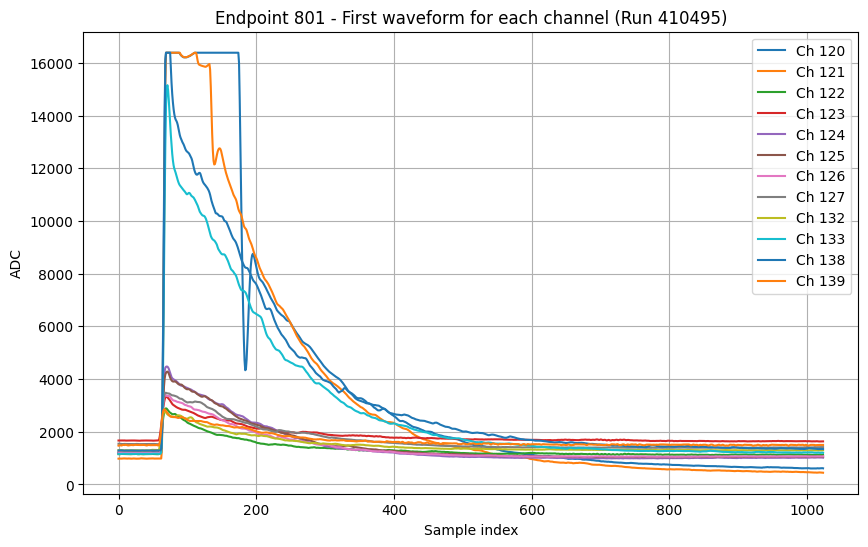

In [8]:
import h5py
import os
import matplotlib.pyplot as plt

def plot_first_waveforms(run_number, base_path="/eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/structured_hdf5s"):
    """
    Plotta la prima waveform di ciascun canale per un run.
    """
    # Path al run
    run_path = os.path.join(base_path, f"run{run_number}")
    
    # Trova file HDF5
    files = [f for f in os.listdir(run_path) if f.endswith(".hdf5")]
    if not files:
        print(f"Nessun file HDF5 trovato per il run {run_number}")
        return
    
    file_path = os.path.join(run_path, files[0])
    print(f"Apro il file: {file_path}")
    
    with h5py.File(file_path, "r") as f:
        adcs = f['adcs'][:]           # shape: (n_waveforms, n_samples)
        channels = f['channels'][:]   # shape: (n_waveforms,)
        
        # Trovo tutti i canali unici
        unique_channels = sorted(set(channels))
        
        plt.figure(figsize=(10,6))
        for ch in unique_channels:
            # Prendo la prima waveform per quel canale
            idx = (channels == ch).nonzero()[0][0]  # indice della prima occorrenza
            plt.plot(adcs[idx], label=f"Ch {ch}")
        
        plt.xlabel("Sample index")
        plt.ylabel("ADC")
        plt.title(f"Endpoint 801 - First waveform for each channel (Run {run_number})")
        plt.legend()
        plt.grid(True)

        plt.show()

# --- Uso ---
plot_first_waveforms(410495)


Apro: /eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/structured_hdf5s/run410495/run_041495_cathode_structured.hdf5
Plotto 100 waveform per canale 125


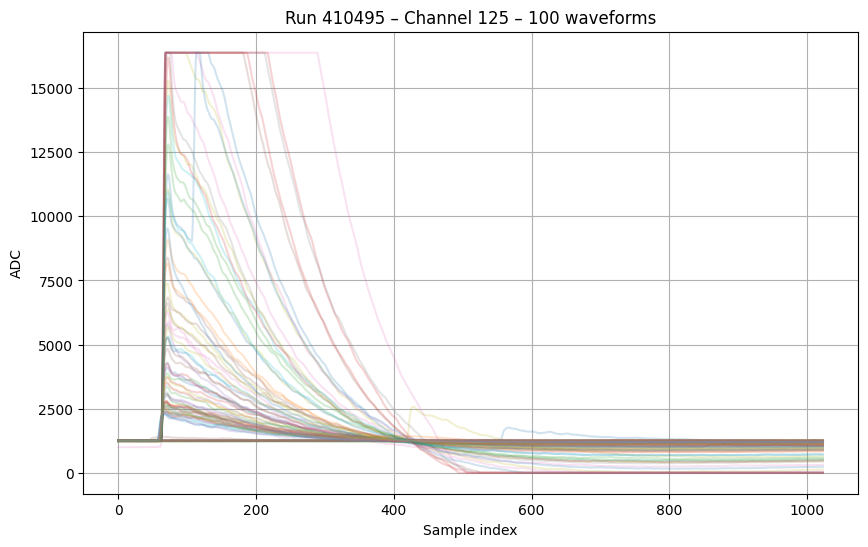

In [20]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_100_waveforms_check(
    run_number,
    channel_to_plot,
    n_wf=100,
    base_path="/eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/structured_hdf5s"
):
    run_path = os.path.join(base_path, f"run{run_number}")
    files = [f for f in os.listdir(run_path) if f.endswith(".hdf5")]
    if not files:
        print("Nessun file trovato")
        return

    file_path = os.path.join(run_path, files[0])
    print(f"Apro: {file_path}")

    with h5py.File(file_path, "r") as f:
        adcs = f["adcs"][:]
        channels = f["channels"][:]

    idxs = np.where(channels == channel_to_plot)[0][:n_wf]

    print(f"Plotto {len(idxs)} waveform per canale {channel_to_plot}")

    plt.figure(figsize=(10, 6))
    for idx in idxs:
        plt.plot(adcs[idx], alpha=0.2)

    plt.xlabel("Sample index")
    plt.ylabel("ADC")
    plt.title(f"Run {run_number} – Channel {channel_to_plot} – {n_wf} waveforms")
    plt.grid(True)
    plt.show()

plot_100_waveforms_check(410495, channel_to_plot=125)

Apro il file: /eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/structured_hdf5s/run410495/run_041495_cathode_structured.hdf5
Numero di waveform per canale 125: 1681


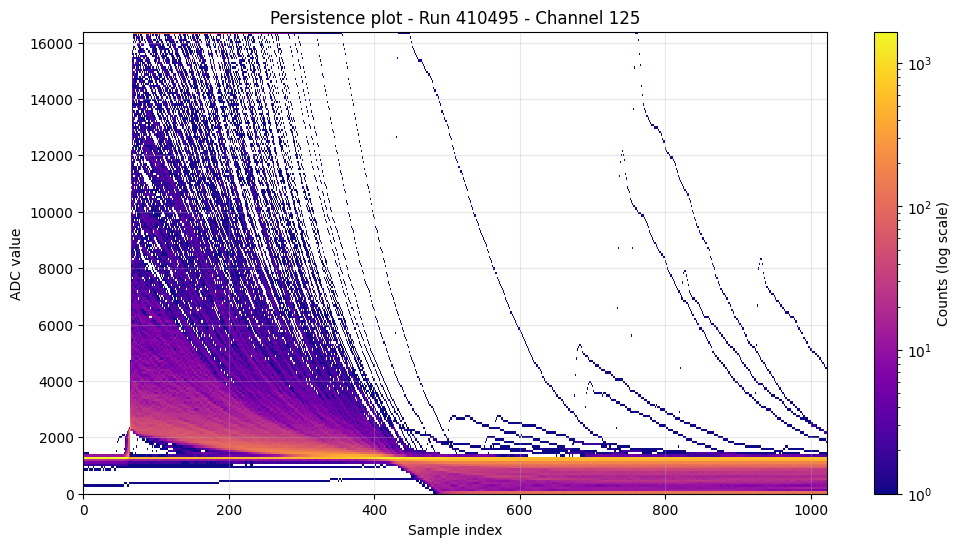

In [21]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # per scala logaritmica

def plot_persistence(run_number, channel=120, base_path="/eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/structured_hdf5s"):
    run_path = os.path.join(base_path, f"run{run_number}")
    files = [f for f in os.listdir(run_path) if f.endswith(".hdf5")]
    
    if not files:
        print(f"Nessun file HDF5 trovato per il run {run_number}")
        return
    
    file_path = os.path.join(run_path, files[0])
    print(f"Apro il file: {file_path}")
    
    with h5py.File(file_path, "r") as f:
        if 'adcs' not in f or 'channels' not in f:
            print("Dataset 'adcs' o 'channels' non trovato.")
            return
        
        adcs = f['adcs'][:]
        channels = f['channels'][:]
        
        # Filtra solo le waveform del canale richiesto
        mask = (channels == channel)
        adcs_channel = adcs[mask]
        
        n_waveforms = adcs_channel.shape[0]
        print(f"Numero di waveform per canale {channel}: {n_waveforms}")
        if n_waveforms == 0:
            print("Nessuna waveform trovata per questo canale.")
            return
        
        # Flatten per histogramma 2D
        x = np.tile(np.arange(adcs_channel.shape[1]), n_waveforms)
        y = adcs_channel.flatten()
        
        plt.figure(figsize=(12,6))
        plt.hist2d(
            x, y, bins=[adcs_channel.shape[1], 200], 
            cmap='plasma', norm=LogNorm()  # colormap leggibile + scala log
        )
        cbar = plt.colorbar()
        cbar.set_label('Counts (log scale)')
        
        plt.xlabel('Sample index')
        plt.ylabel('ADC value')
        plt.title(f'Persistence plot - Run {run_number} - Channel {channel}')
        plt.grid(True, alpha=0.3)
        plt.show()

# --- Esempio di uso ---
plot_persistence(410495, channel=125)
